## Data processing

In [162]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav

%matplotlib inline

PATH = './vowels/'

In [163]:
import enum

def getGenderFromFilename(filename):
    
    if(filename[2] == 'f'):
        return 1 # female
    elif(filename[2] == 'm'):
        return 0 # male
    else:
        return 2 # kid
    
def getVoiceTypeFromFilename(filename):
    if(filename[0] == 's'):
        return 0 # syntetic voice
    else:
        return 1 # real voice
    
def isAdult(filename):
    return filename[1] != 'k'


In [164]:
from pathlib import Path
from python_speech_features import mfcc

mfccRawDatas = []

#Read all the wav files
pathlist = Path(PATH).glob('*.wav')
for path in pathlist:
    sample_rate, X = wav.read(str(path))
    category = getGenderFromFilename(path.stem)

    voiceType = getVoiceTypeFromFilename(path.stem)
    #TODO : maybe add age here...

    #Append the data as a tuple of : (category (male, female or kid), voicetype (natural or synthetic),Mfcc data)
    mfccRawDatas.append((category, voiceType, mfcc(X, samplerate = sample_rate, nfft = 1024)))


In [166]:
mfccDatas = []
#Recuce the MFCCs datas with a mean of all values
for i in range(len(mfccRawDatas)) :
    #Take the means of all windows
    values = mfccRawDatas[i][2].mean(axis=0)
    #Add the gender
    values = np.append(values, mfccRawDatas[i][0])
    #Add the voicetype
    values = np.append(values, mfccRawDatas[i][1])
    #Put the row in the array
    mfccDatas.append(values)
    

In [167]:
#For the rest of the first phase, we'll take only male and female datas.
datas = []
for d in mfccDatas:
    if(d[-2] != 2):
        datas.append(d)


In [183]:
#We shuffle the datas and split into trainset and testset
def split_dataset(dataset, train_test_ratio=0.7):
    np.random.shuffle(dataset)
    nb_train = int(len(dataset) * train_test_ratio)
    
    trainSet = np.asarray(dataset[:nb_train])
    testSet  = np.asarray(dataset[nb_train:])
    
    X_train = trainSet[:, :-2]
    Y_train = trainSet[:, -2:-1]

    X_test = testSet[:, :-2]
    Y_test = testSet[:, -2:-1]
    
    return (X_train, Y_train, X_test, Y_test)

## Training part

In [186]:
import mlp_backprop_momentum as mlp
%matplotlib inline

In [197]:
NB_SPLIT = 3
MSE = [None] * NB_SPLIT
MSE_test = [None] * NB_SPLIT

for split in range(NB_SPLIT):
    X_train, Y_train, X_test, Y_test = split_dataset(datas)

    # Init the neural network
    nn = mlp.MLP([13, 5, 1], 'tanh')
    # 13 inputs (for the 13 mfcc values )
    # 5 hidden nodes
    # 1 output (female or male)

    MSE[split], MSE_test[split] = nn.fit((X_train, Y_train), (X_test, Y_test) , learning_rate=0.001, momentum=0.7, epochs=120)


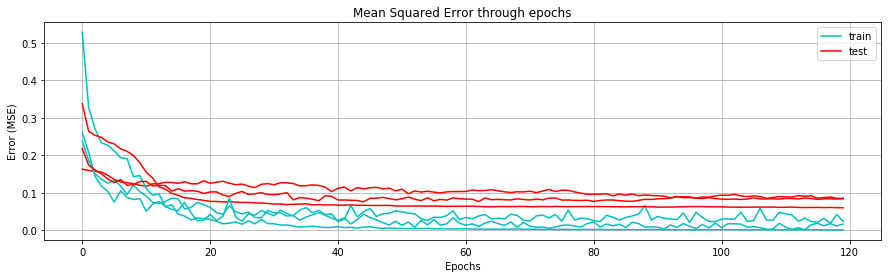

In [202]:
    
pl.figure(figsize=(15,4))
pl.ylabel('Error (MSE)')
pl.xlabel('Epochs')

for split in range(NB_SPLIT):
    # plot the error through the iterations of the algorithm
    pl.plot(MSE[split], c='c' , label= 'train')
    pl.plot(MSE_test[split], c='r' ,label='test')
    if(split == 0):
        pl.legend()
pl.title('Mean Squared Error through epochs')

pl.grid()


In [175]:
output = nn.compute_output(X_train)

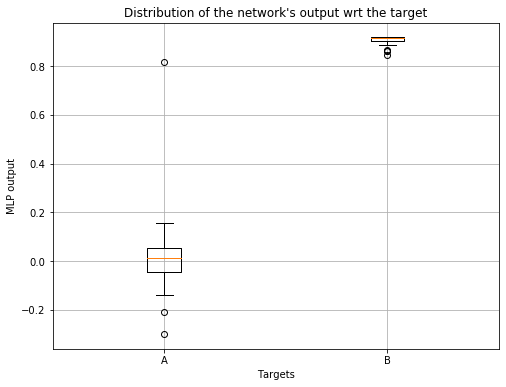

In [176]:
pl.figure(figsize=(8,6))
pl.boxplot([output[Y_train==0], output[Y_train==1.0]])
pl.xticks([1, 2], ['A', 'B'])
pl.xlabel('Targets')
pl.ylabel('MLP output')
pl.title("Distribution of the network's output wrt the target")
pl.grid()

# Validation